Problem Statement:
One of the challenge for all Pharmaceutical companies is to understand the persistency of drug as
per the physician prescription.

With an objective to gather insights on the factors that are impacting the persistency, build a
classification for the given dataset.
Target Variable: Persistency_Flag
Variable description is attached along with the data.
Model Evaluation:
Following are the things we are expecting in the submission:
1. R/Python code (executable) used for the analysis (with proper comments and readability).
If it’s a Jupyter notebook with all the results in it, that will be best!
2. Model diagnostics to be updated in the attached excel template (Excel File: Analysis Results)
3. Final Analytical (processed) dataset used, which includes the additional derived variables
and any other processing applied
4. Attach a document along with brief description of following in the mail:
a. Changes done in the analytical dataset provided
b. Any other highlights about the process you followed to ensure a thorough
evaluation

In [94]:
# General Utils
# General Utils

import warnings
import logging

class GeneralUtils():
    def __init__(self):
        pass
    
    def ignore_warning(self):
        """
        Ignores the warnings printing
        """
        warnings.filterwarnings('ignore')
        return
    
    def set_logging_level_to_info(self):
        logging.getLogger().setLevel(logging.INFO)

    
genutils = GeneralUtils()
genutils.ignore_warning()
genutils.set_logging_level_to_info()

In [205]:
# Visualisation Utils 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

class Visualisations():
    def __init__(self):
        %matplotlib inline
        
    def plot_null_value_analysis(self, data_frame, custom_title=""):    
        """
        Args:
                data_frame (pd.DataFrame) : input dataframe for plotting
                column : column for which value counts need to analysed
        Returns:
                None
        """
        
        #plot null values percentage
        null_count = data_frame.isnull().sum().reset_index()                                                                    #calculate total null values in each column
        null_valued_columns = null_count[null_count[0] > 0]["index"].to_list()                                          #keep only columns that has atleast one null value
        percent_missing = ((data_frame.isnull().sum() / len(data_frame)) * 100).reset_index()                                           #calculate percentage of null values with over all size of data
        percent_missing.columns = ['column_name', 'missing_percent']                                                    #rename columns 
        percent_missing = percent_missing[percent_missing['missing_percent'] > 0]                                       #keep only columns with >0% null values

        plt.figure(figsize=(22,8))
        ax = sns.barplot(x="column_name", y="missing_percent", data=percent_missing)
        plt.title(f"{custom_title} features null values percentage")
        plt.xlabel("FEATURES")
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            if(y<90):
                ax.annotate('{:.2f}%'.format(y), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text
            else:
                ax.annotate('{:.2f}%'.format(y), (x.mean(), 50), ha='center', va='bottom') # set the alignment of the text
        ax.set_ylim(0,100)
        ax.grid()
        plt.xticks(rotation=90)
        plt.show()
    
        #plot null values distribution
        plt.figure(figsize=(22,8))
        sns.heatmap(data_frame.isnull(), cbar=False)
        plt.title(f"{custom_title} features null values records distribution")
        plt.show()
    
    def count_plot_analysis(self, data_frame, column, hue=None, custom_title=""):
        """
        Args:
                data_frame (pd.DataFrame) : input dataframe for plotting
                column : column for which value counts need to analysed
        Returns:
                None
        """
        ncount = len(data_frame)        
        plt.figure(figsize=(16,5))
        ax = sns.countplot(x=column , data=data_frame, hue=hue)
        plt.title(f"{custom_title} | Distribution of {column} | Number of unique values {data_frame[column].nunique()}")
        plt.xlabel('Values')
        plt.xticks(rotation=45)
        
        # Make twin axis
        ax2=ax.twinx()
        ax2.yaxis.tick_left() # Switch so count axis is on right, frequency on left
        ax.yaxis.tick_right()
        # Also switch the labels over
        ax.yaxis.set_label_position('right')
        ax2.yaxis.set_label_position('left')
        ax2.set_ylabel('Frequency [%]')
        
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text
        
        # Use a LinearLocator to ensure the correct number of ticks
        ax.yaxis.set_major_locator(ticker.LinearLocator(11))

        # Fix the frequency range to 0-100
        ax2.set_ylim(0,100)
        ax.set_ylim(0,ncount)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
        ax2.grid(None)
        plt.show()
        
    def plot_confusion_matrix(self, actuals, predicted):
        from pretty_confusion_matrix import pp_matrix_from_data
        pp_matrix_from_data(actuals, predicted, columns=['Persistent', 'Non-Persistent'])
        plt.show()
        
    def plot_roc_curve(self, false_positive_rate, true_positive_rate):
        plt.plot(false_positive_rate, true_positive_rate)
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        
        
        
visutil = Visualisations()

In [96]:
#DataFrame Utils

import pandas as pd


class DataFrameUtils():
    """
    This calss contains some of the utilities related to pandas actions
    """
    def __init__(self):
        """
        Initialise prerequisites for pandas operations
        """
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', 20)
        
        
    def get_numeric_columns(self, data_frame):
        """
        Args :
            dataframe (pd.DataFrame) : pandas dataframe
            
        return:
            numeric_columns (list) : list of column name having numeric data
        """
        numeric_columns = list(data_frame._get_numeric_data().columns)
        return numeric_columns
    
    def get_categorical_columns(self, data_frame):
        """
        Args :
            dataframe (pd.DataFrame) : pandas dataframe
            
        return:
            categorical (list) : list of column name having categorical data
        """
        categorical = list(data_frame.select_dtypes(['object']).columns)
        return categorical
        
            
    def appendTwoDataFrames(self, data_frame1, data_frame2):
        """
            Args:
                data_frame1 (pd.DataFrame) : pandas first dataframe
                data_frame2 (pd.DataFrame) : pandas second dataframe
            Returns:
                data_frame (pd.DataFrame) : appended dataframe
        """
        try:
            data_frame = data_frame1.append(data_frame2, ignore_index=True)
            logging.info(f"successully appended dataframes")
            return data_frame

        except Exception as e:
            logging.critical(f"Error while appending dataframes : {e}")
            logging.error(e)
        

dfutils = DataFrameUtils()

In [97]:
import pandas as pd

df = pd.read_excel("Case Study Data scientist Challenge_dataset_Persistent_Non_Persistent.xlsx", sheet_name="Dataset")
df.columns = [col.lower().strip() for col in df.columns]
df.head()

,ptid,persistency_flag,gender,race,ethnicity,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,risk_segment_during_rx,tscore_bucket_during_rx,change_t_score,change_risk_segment,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


In [98]:
print(f"Number of duplicate records in the data {df.duplicated().sum()}")

Number of duplicate records in the data 0


In [99]:
print(f"Number of columns having null values = {df.isnull().sum().sum()}")

Number of columns having null values = 0


In [100]:
#check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   ptid                                                                3424 non-null   object
 1   persistency_flag                                                    3424 non-null   object
 2   gender                                                              3424 non-null   object
 3   race                                                                3424 non-null   object
 4   ethnicity                                                           3424 non-null   object
 5   region                                                              3424 non-null   object
 6   age_bucket                                                          3424 non-null   object
 7   ntm_speciality          

* **Observation (Numeric Data) :**
    * dexa_freq : Number of DEXA scans taken prior to the first NTM Rx date (within 365 days prior from rxdate)
        * As seen there are average of 3 scans in 365 days and max is 146 which is exceptional as per mean, need to check for outliers for this feature
    * count_of_risks : There are max upto 7 risks with std of ~1 which is kind of normally distributed
    
* **oservation (Categorical Data):**
    * By observing disribution, there are many features skewed toward specific values for ex: ethnicity 3235 of 3424 belongs to a specific catefory these kind of features will not influence model in any way
    
##### **To proceed with is these skewed features having relation with target feature lets analyse the count plot of certain categorical features**

In [101]:
#Seperate out numerical and categorical columns and observe distribution of features
numeric_cols = dfutils.get_numeric_columns(df)
categorical_cols = dfutils.get_categorical_columns(df)

display(df[numeric_cols].describe())
display(df[categorical_cols].describe(include='O'))

,dexa_freq_during_rx,count_of_risks
count,3424.000000,3424.000000
mean,3.016063,1.239486
std,8.136545,1.094914
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,3.000000,2.000000
max,146.000000,7.000000


,ptid,persistency_flag,gender,race,ethnicity,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,risk_segment_during_rx,tscore_bucket_during_rx,change_t_score,change_risk_segment,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls
count,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
unique,3424,2,2,4,3,5,4,36,2,3,2,2,2,2,2,2,2,3,3,4,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,P1,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,No change,Unknown,Adherent,Y,Y,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
freq,1,2135,3230,3148,3235,1383,1439,1535,2013,2104,2619,2522,2488,2872,3007,1931,1951,1497,1497,1660,2229,3251,2557,3056,1891,1911,2072,2331,2425,2633,2607,2645,2747,2906,1765,2507,2775,2794,2242,2191,2451,2465,2787,2821,2853,2985,2927,3071,3285,3421,3294,3422,3297,3412,3168,2780,2954,3406,3066,3382,1788,3232,3357,3370,3413,3410,3355


* Observation :
    * Data is sligtly imbalanced towards Non persistent, 

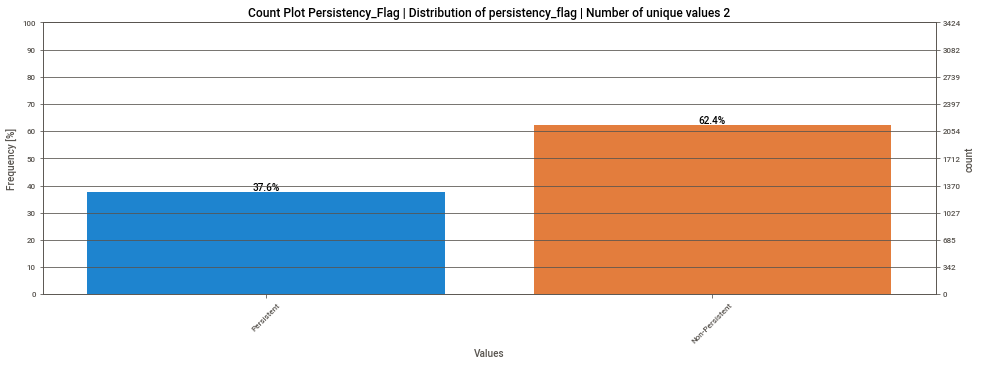

In [102]:
visutil.count_plot_analysis(df, "persistency_flag", custom_title=f"Count Plot Persistency_Flag")

# **EDA AND FE**
<hr>

* Lets analyse group by group

<center><H1><b>Demographics and Clinical Factors<b><H1><center>
<img src="reference_images/demographics.png">
<img src="reference_images/clinical_factors.png">

* Observation 
    * out of below features gender and adherant_flag seems to have imact on target feature
    * Other features link race skewed towards Caucasian, ethnicity towards Non Hisbanic so we can drop hese 2 features

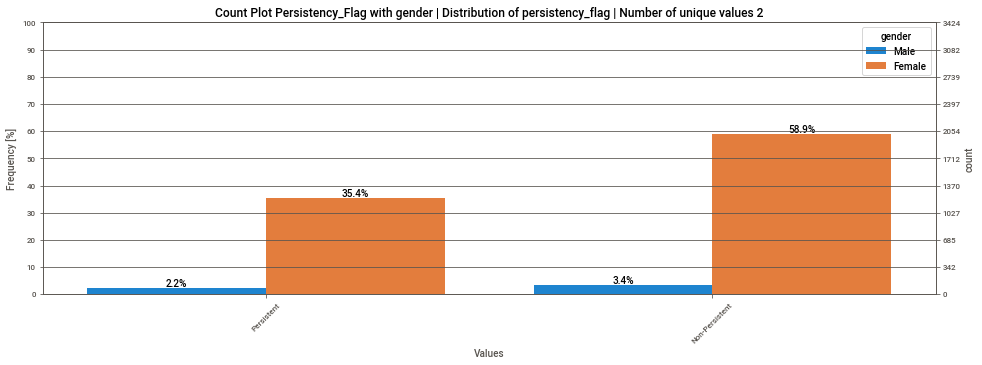

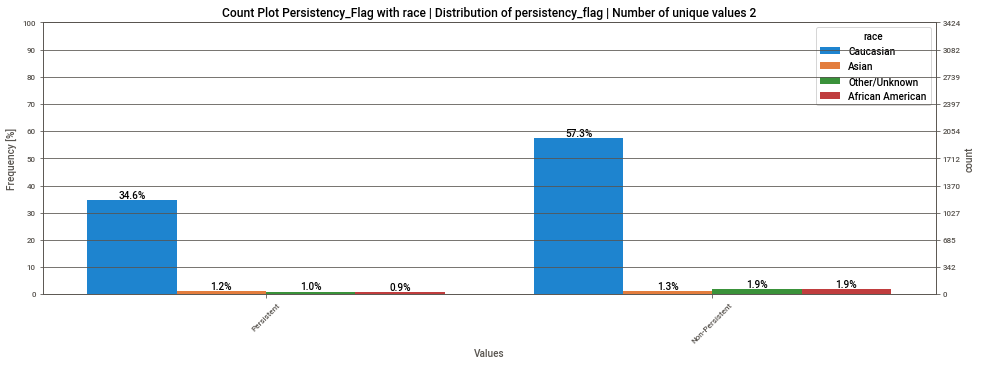

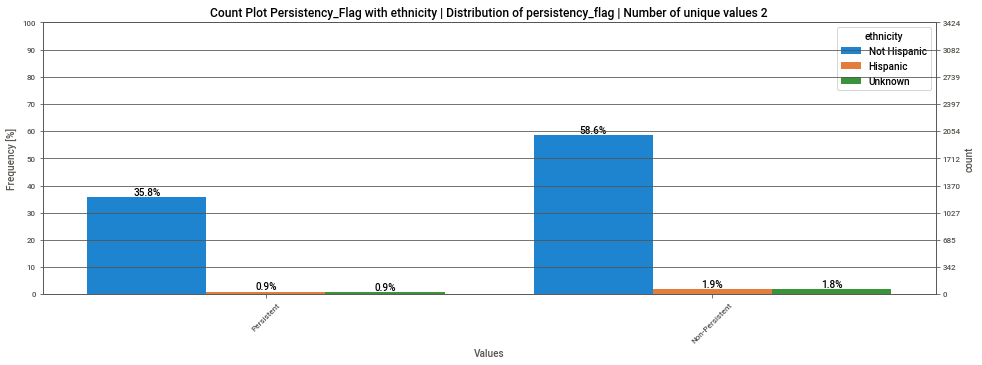

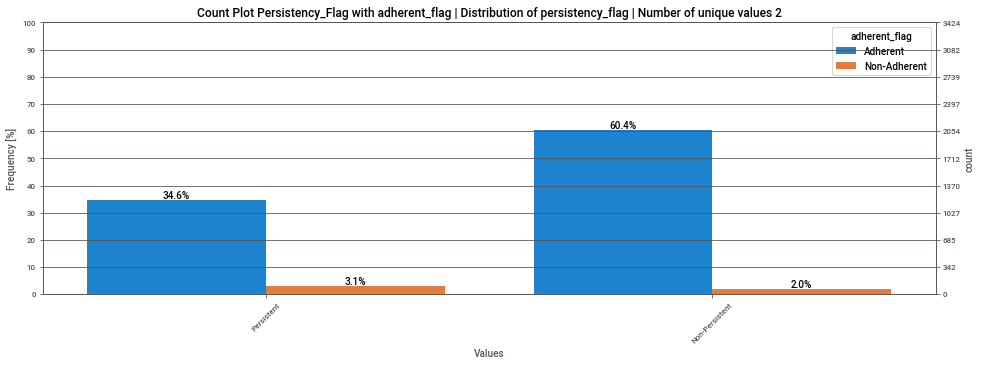

In [103]:
highly_skewd_features = ['gender','race','ethnicity','adherent_flag']
for feature in highly_skewd_features:
    visutil.count_plot_analysis(df, "persistency_flag", custom_title=f"Count Plot Persistency_Flag with {feature}", hue=feature)

* Observation :
    * Lets analyse few more columns having unknown as category
    * As we can see majority of them belowng to unknown and for change_tscore either unknown or no change, there will not be much influence of these features we can drop

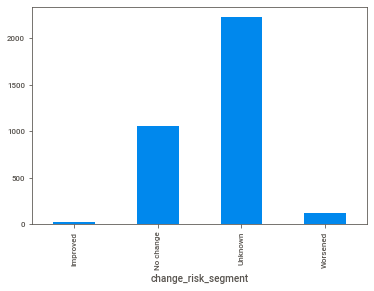

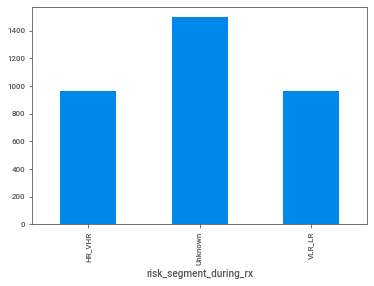

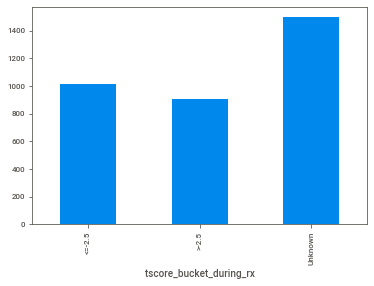

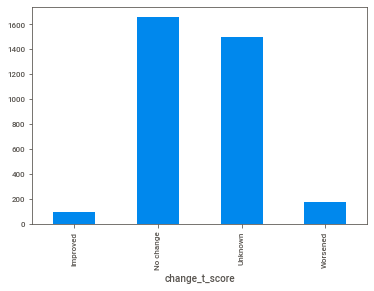

In [104]:
features_to_analyse = ['change_risk_segment','risk_segment_during_rx','tscore_bucket_during_rx','change_t_score']
for feature in features_to_analyse:
    df.groupby(feature)["persistency_flag"].count().plot(kind='bar')
    plt.show()

* Observation :
    * we can see that most of the samples belong to >55 age people
    * we can see tscore bucket to have some sort of influence

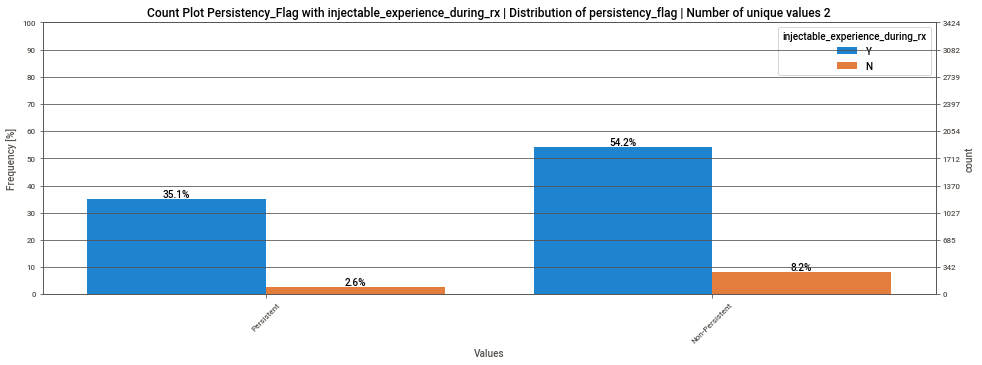

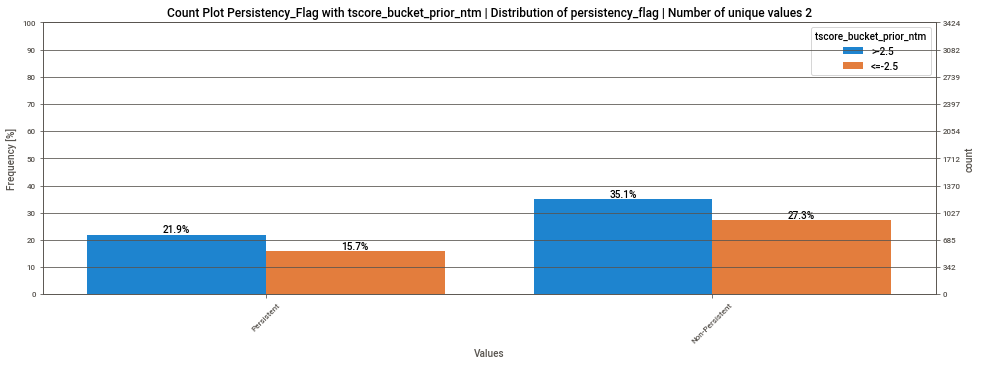

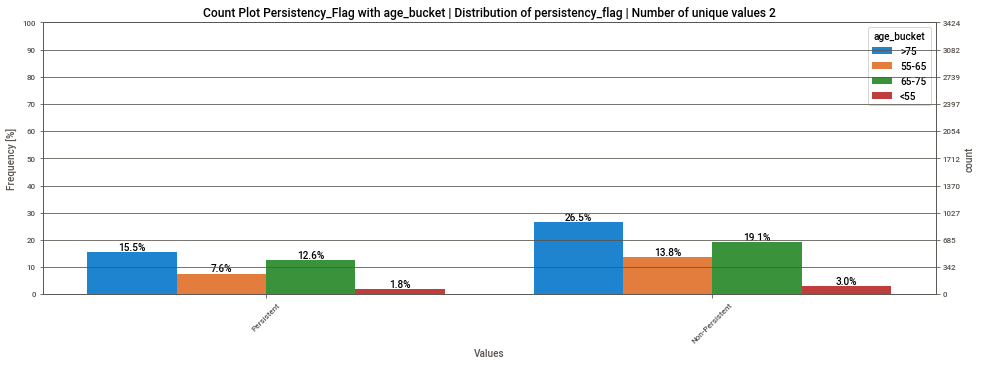

In [105]:
features_to_analyse = ['injectable_experience_during_rx','tscore_bucket_prior_ntm','age_bucket']
for feature in features_to_analyse:
    visutil.count_plot_analysis(df, "persistency_flag", custom_title=f"Count Plot Persistency_Flag with {feature}", hue=feature)

In [106]:
features_to_drop = ['race', 'ethnicity', 'change_risk_segment','risk_segment_during_rx','tscore_bucket_during_rx','change_t_score']
df = df.drop(columns=features_to_drop)

In [107]:
df.head()

,ptid,persistency_flag,gender,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks
0,P1,Persistent,Male,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


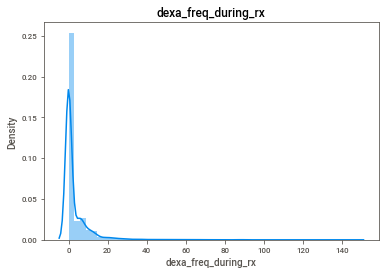

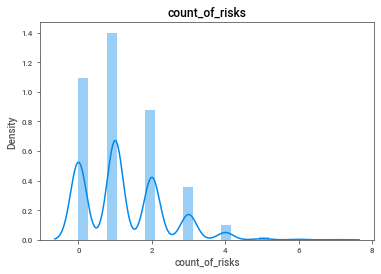

In [108]:
for col in numeric_cols:
    sns.distplot(df[col])
    plt.title(col)
    plt.show()
    

In [80]:
import sweetviz

eda = sweetviz.analyze(df)
eda.show_html('Report.html')

Done! Use 'show' commands to display/save.   |██| [100%]   00:06 -> (00:00 left)


Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<hr>

<center><H1><b>DISEASE / TREATMENT FACTORS</b></center>

<img src="reference_images/catalog_disease_treatment_factor.png">

* Disease/Treatment Factor
    * Risk Factors
    * Comorbidity
    * Concomitancy

In [122]:
risk_factors_columns = [col for col in df.columns if col.startswith("risk")]
risk_factors_columns.remove("risk_segment_prior_ntm")
comorb_factors_columns = [col for col in df.columns if col.startswith("comorb")]
concom_factors_columns = [col for col in df.columns if col.startswith("concom")]

In [123]:
disease_or_treatment_factor_columns = risk_factors_columns + comorb_factors_columns + concom_factors_columns

In [132]:
df['number_of_risk_factors_for_ptid'] = (df[risk_factors_columns] == 'Y').sum(axis=1)
df['number_of_comorb_factors_for_ptid'] = (df[comorb_factors_columns] == 'Y').sum(axis=1)
df['number_of_concom_factors_for_ptid'] = (df[concom_factors_columns] == 'Y').sum(axis=1)

In [133]:
df.head()

,ptid,persistency_flag,gender,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks,number_of_risk_factors_for_ptid,number_of_comorb_factors_for_ptid,number_of_concom_factors_for_ptid
0,P1,Persistent,Male,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5,0
1,P2,Non-Persistent,Male,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1,0
2,P3,Non-Persistent,Female,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,2,2,1
3,P4,Non-Persistent,Female,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,1,6,3
4,P5,Non-Persistent,Female,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,1,5,3


# **ENCODING**

* **PERSISTENT : 0**
* **NON-PERSISTENT : 1**

In [138]:
#lets apply onehot encoding for 2 categories features
df[disease_or_treatment_factor_columns] = pd.get_dummies(df[disease_or_treatment_factor_columns], drop_first=True)
df

,ptid,persistency_flag,gender,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks,number_of_risk_factors_for_ptid,number_of_comorb_factors_for_ptid,number_of_concom_factors_for_ptid
0,P1,1,1,4,3,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1,P2,0,1,4,0,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P3,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,2,2,1
3,P4,0,0,0,3,5,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,6,3
4,P5,0,0,0,3,5,0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,1,0,3,3,5,0,1,0,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,7,5
3420,P3421,1,0,3,3,34,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3421,P3422,1,0,3,3,3,1,0,0,0,7,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,4,3
3422,P3423,0,0,3,0,34,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [139]:
#lets apply onehot encoding for 2 categories features
two_category_fearures = ['persistency_flag','gender','ntm_specialist_flag','gluco_record_prior_ntm','gluco_record_during_rx','dexa_during_rx','frag_frac_during_rx','risk_segment_prior_ntm','tscore_bucket_prior_ntm','adherent_flag','idn_indicator','injectable_experience_during_rx','frag_frac_prior_ntm']
df[two_category_fearures] = pd.get_dummies(df[two_category_fearures], drop_first=True)
df

,ptid,persistency_flag,gender,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks,number_of_risk_factors_for_ptid,number_of_comorb_factors_for_ptid,number_of_concom_factors_for_ptid
0,P1,1,1,4,3,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1,P2,0,1,4,0,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P3,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,2,2,1
3,P4,0,0,0,3,5,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,6,3
4,P5,0,0,0,3,5,0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,1,0,3,3,5,0,1,0,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,7,5
3420,P3421,1,0,3,3,34,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3421,P3422,1,0,3,3,3,1,0,0,0,7,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,4,3
3422,P3423,0,0,3,0,34,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [140]:
#Encoding features with multiple categories
multiple_class = ['age_bucket','ntm_speciality','ntm_speciality_bucket','region']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in multiple_class:
    df[col] = le.fit_transform(df[col])

In [141]:
df

,ptid,persistency_flag,gender,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_freq_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,adherent_flag,idn_indicator,injectable_experience_during_rx,comorb_encounter_for_screening_for_malignant_neoplasms,comorb_encounter_for_immunization,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx",comorb_vitamin_d_deficiency,comorb_other_joint_disorder_not_elsewhere_classified,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx,comorb_long_term_current_drug_therapy,comorb_dorsalgia,comorb_personal_history_of_other_diseases_and_conditions,comorb_other_disorders_of_bone_density_and_structure,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias,comorb_osteoporosis_without_current_pathological_fracture,comorb_personal_history_of_malignant_neoplasm,comorb_gastro_esophageal_reflux_disease,concom_cholesterol_and_triglyceride_regulating_preparations,concom_narcotics,concom_systemic_corticosteroids_plain,concom_anti_depressants_and_mood_stabilisers,concom_fluoroquinolones,concom_cephalosporins,concom_macrolides_and_similar_types,concom_broad_spectrum_penicillins,concom_anaesthetics_general,concom_viral_vaccines,risk_type_1_insulin_dependent_diabetes,risk_osteogenesis_imperfecta,risk_rheumatoid_arthritis,risk_untreated_chronic_hyperthyroidism,risk_untreated_chronic_hypogonadism,risk_untreated_early_menopause,risk_patient_parent_fractured_their_hip,risk_smoking_tobacco,risk_chronic_malnutrition_or_malabsorption,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks,number_of_risk_factors_for_ptid,number_of_comorb_factors_for_ptid,number_of_concom_factors_for_ptid
0,P1,1,1,4,3,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1,P2,0,1,4,0,5,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P3,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,2,2,1
3,P4,0,0,0,3,5,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,6,3
4,P5,0,0,0,3,5,0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,1,0,3,3,5,0,1,0,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,7,5
3420,P3421,1,0,3,3,34,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3421,P3422,1,0,3,3,3,1,0,0,0,7,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,4,3
3422,P3423,0,0,3,0,34,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [142]:
df.dtypes

ptid                                 object
persistency_flag                      uint8
gender                                uint8
region                                int64
age_bucket                            int64
                                      ...  
risk_recurring_falls                  uint8
count_of_risks                        int64
number_of_risk_factors_for_ptid       int64
number_of_comorb_factors_for_ptid     int64
number_of_concom_factors_for_ptid     int64
Length: 66, dtype: object

In [143]:
df.shape

(3424, 66)

In [144]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
df[['dexa_freq_during_rx','number_of_concom_factors_for_ptid', 'number_of_comorb_factors_for_ptid','number_of_risk_factors_for_ptid']] = scaling.fit_transform(df[['dexa_freq_during_rx','number_of_concom_factors_for_ptid', 'number_of_comorb_factors_for_ptid','number_of_risk_factors_for_ptid']])

<hr>

## **Feature Selection**

- **Mutual Information Classifier** is one of the feature selection method method.
- Before applying feature selection will sperate out Independent and Dependent Features

In [145]:
# Splitting the data 
data = df.copy()
target_feature = data[['persistency_flag']]
independent_features = data.drop(['ptid','persistency_flag'],axis=1)

In [146]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
fs = SelectKBest(score_func=mutual_info_classif,k= 15)
fs.fit(independent_features , target_feature.values.ravel())

SelectKBest(k=15, score_func=<function mutual_info_classif at 0x7f9467511f70>)

Each feature will be assigned a score based on their relevancy to the taret variable. We can pass those values into a dataframe and sort them based their scores 

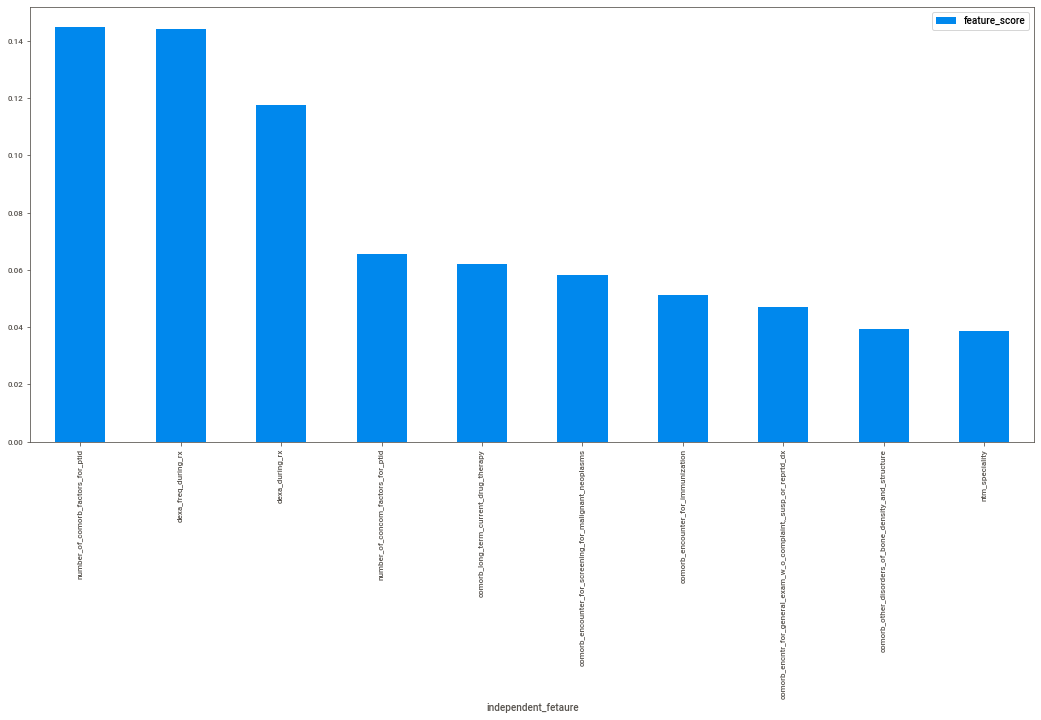

,independent_fetaure,feature_score
0,number_of_comorb_factors_for_ptid,0.144768
1,dexa_freq_during_rx,0.144281
2,dexa_during_rx,0.117500
3,number_of_concom_factors_for_ptid,0.065471
4,comorb_long_term_current_drug_therapy,0.062107
5,comorb_encounter_for_screening_for_malignant_n...,0.058298
6,comorb_encounter_for_immunization,0.051292
7,"comorb_encntr_for_general_exam_w_o_complaint,_...",0.046894
8,comorb_other_disorders_of_bone_density_and_str...,0.039388
9,ntm_speciality,0.038616


In [156]:
from matplotlib import rc
rc('font', weight='bold')
feature_columns=independent_features.columns
feature_list = []
for i in range(len(fs.scores_)):
    feature_list.append([feature_columns[i],fs.scores_[i]])
feature_df = pd.DataFrame(feature_list)
feature_df = feature_df.sort_values(1,ascending=False)
feature_df.columns = ['independent_fetaure','feature_score']
feature_df.set_index('independent_fetaure', inplace=True)
feature_df[:10].plot(kind='bar', figsize=(18,8))
feature_df = feature_df.reset_index()
plt.show()
display(feature_df[:10])

* will select top 10 features for modeling

In [157]:
selected_columns_for_modeling = feature_df['independent_fetaure'][:10].tolist()

In [159]:
# Filtering the selected columns
independent_features_data_for_modeling = independent_features[selected_columns_for_modeling]

In [160]:
all_features_for_modeling = selected_columns_for_modeling + ['persistency_flag']

In [161]:
test = df[all_features_for_modeling].drop_duplicates()

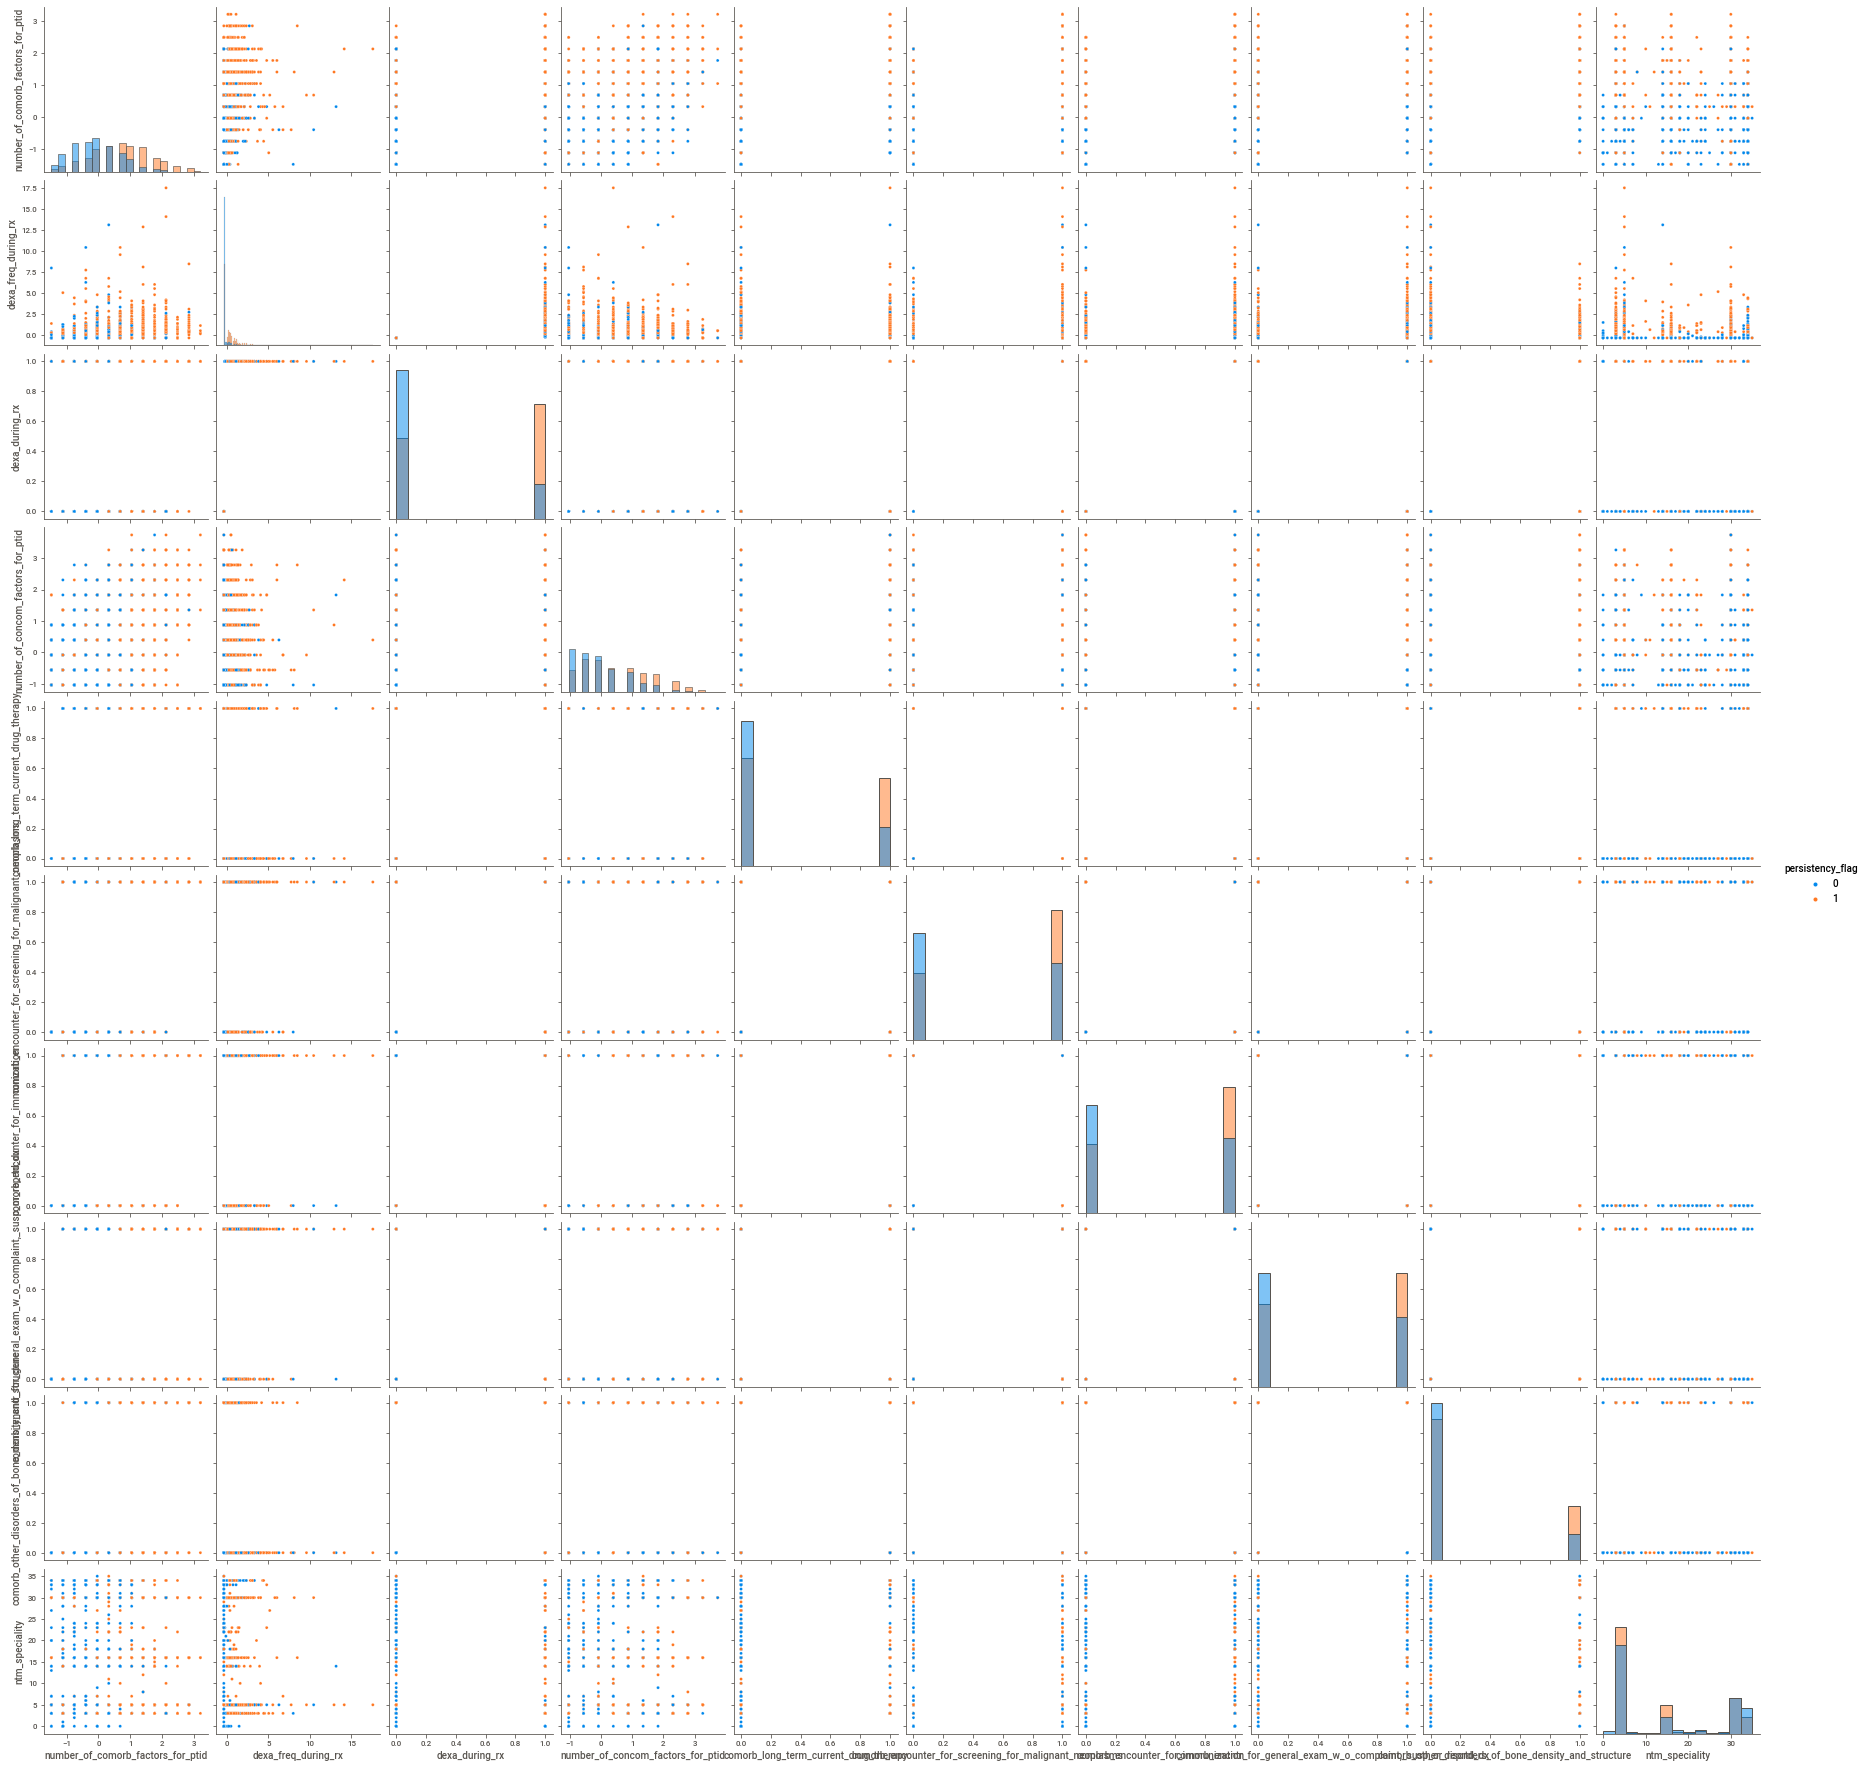

In [163]:
sns.pairplot(test,hue = 'persistency_flag', diag_kind = 'hist')

--

# **HANDLING IMBALANCED DATASET**


Now that we have selected the required features, we can fix the imbalanced dataset.

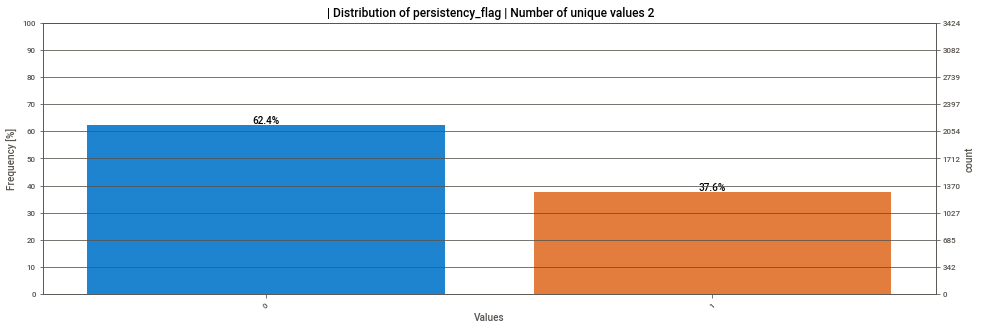

In [165]:
visutil.count_plot_analysis(target_feature, "persistency_flag")

We can oversample our dataset using SMOTE to increase the number of **Persistent Flags**

In [167]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
independent_features_data_for_modeling,target_feature = oversample.fit_resample(independent_features_data_for_modeling, target_feature)

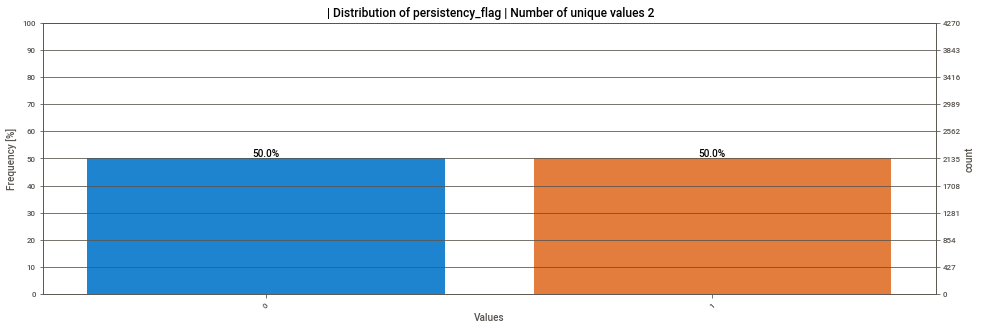

In [168]:
visutil.count_plot_analysis(target_feature, "persistency_flag")

* Now we have balanced Dataset

----

## **CLASSIFICATION MODELS**

##### Splitting data

In [171]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV
x_train, x_test,y_train, y_test = train_test_split(independent_features_data_for_modeling,target_feature,train_size = 0.8, random_state = 0)

### **Models for training**

* Lets train 3 models for classification with cv to test models 
1. Logistic Regression
2. Decision Trees
3. Random Forest

In [172]:
performance_metrics_list=[]

### 1. Logistic Regression

In [176]:
from sklearn.linear_model import LogisticRegression
import numpy as np
logreg = LogisticRegression()
logreg.fit(x_train, y_train.values.ravel())
scores = cross_val_score(logreg,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_metrics_list.append(['Logistic Regression',np.mean(scores)])

### 2. Decision Tree

In [182]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
scores = cross_val_score(dtc,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_metrics_list.append(['Decision Tree',np.mean(scores)])

### 3. Random Forest

In [183]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators= 300)
random_forest.fit(x_train, y_train.values.ravel())
scores = cross_val_score(random_forest,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_metrics_list.append(['Random Forest',np.mean(scores)])

---- 

## **Model Selection**
selecting best model based on mean score

In [184]:
performance_metrics_df = pd.DataFrame(performance_metrics_list)
performance_metrics_df.columns = ['MODEL','MEAN ROC AUC']
performance_metrics_df.sort_values('MEAN ROC AUC',ascending = False)

,MODEL,MEAN ROC AUC
2,Random Forest,0.885447
0,Logistic Regression,0.860262
1,Decision Tree,0.777537


* Random forest model has highest ROC AUC score will select that model for hyper parameter tuning

----

## **Hyperparameter Tuning RANDOM FOREST MODEL**
* applying grid search

In [185]:
# parameters of random forest algorithm
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [186]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=None, n_jobs = -1)
rf_random.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/abhishek/local_disk/coding/practice_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhishek/local_disk/coding/practice_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhishek/local_disk/coding/practice_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=1)

In [187]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

----

## **Evaluating model performance**

In [190]:
#Training the model on best parameters

random_forest = RandomForestClassifier(n_estimators= 400,min_samples_split = 5,min_samples_leaf=1,max_features='sqrt',max_depth =30, bootstrap = True)
random_forest.fit(x_train, y_train.values.ravel())
y_pred = random_forest.predict(x_test)

### **Confusion matrix**

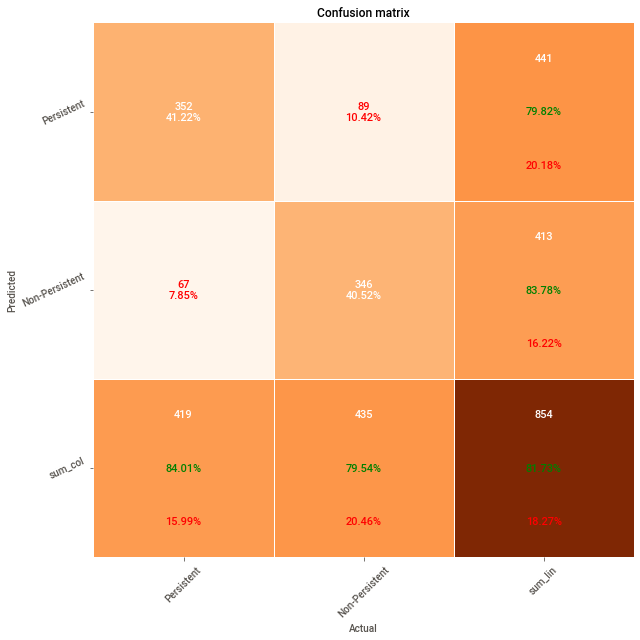

In [199]:
visutil.plot_confusion_matrix(y_test, y_pred)

* ### F1 Score

In [200]:
from sklearn.metrics import accuracy_score,f1_score,roc_curve, auc,confusion_matrix,classification_report
f1 = f1_score(y_test,output) 
print('F1 score:',f1)

F1 score: 0.8089622641509434


* ### AUC

In [201]:
rf_y_pred_proba = random_forest.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under Curve:',roc_auc)

Area under Curve: 0.894329684799605


### Plotting ROC curve

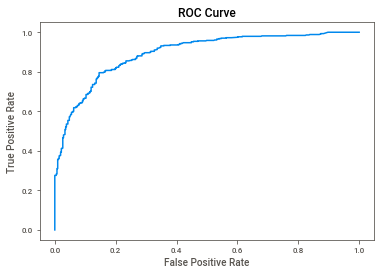

In [206]:
visutil.plot_roc_curve(false_positive_rate, true_positive_rate)

### Precision and recall values

* **PERSISTENT : 0**
* **NON-PERSISTENT : 1**

In [207]:
class_report = classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       419
           1       0.84      0.80      0.82       435

    accuracy                           0.82       854
   macro avg       0.82      0.82      0.82       854
weighted avg       0.82      0.82      0.82       854



----
# **KFOLD CV for random forest**

In [208]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 10, shuffle = True, random_state = 10)
scores_list = []
i = 1
# enumerate splits
for train, test in kfold.split(independent_features_data_for_modeling):
    x_train, y_train = independent_features_data_for_modeling.iloc[train], target_feature.iloc[train]
    x_test, y_test = independent_features_data_for_modeling.iloc[test], target_feature.iloc[test]
    random_forest = RandomForestClassifier(n_estimators= 1600,min_samples_split = 10,min_samples_leaf=1,max_features='sqrt',max_depth =20, bootstrap = True)
    random_forest.fit(x_train, y_train.values.ravel())
    rf_y_pred_proba = random_forest.predict_proba(x_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('Iteration:',i)
    print('ROC AUC Score:',roc_auc)
    scores_list.append(roc_auc)
    i = i + 1
print('Mean ROC AUC Score:', np.mean(scores_list))

Iteration: 1
ROC AUC Score: 0.9169383259911895
Iteration: 2
ROC AUC Score: 0.8846500483601513
Iteration: 3
ROC AUC Score: 0.8817083882301273
Iteration: 4
ROC AUC Score: 0.890548900881927
Iteration: 5
ROC AUC Score: 0.903801413458584
Iteration: 6
ROC AUC Score: 0.8951002814919071
Iteration: 7
ROC AUC Score: 0.8983110485573541
Iteration: 8
ROC AUC Score: 0.9110723531218463
Iteration: 9
ROC AUC Score: 0.9105785704871941
Iteration: 10
ROC AUC Score: 0.9043403769274702
Mean ROC AUC Score: 0.899704970750775


----

## **Model Summary:**

For classification of persitency of drug we could see after the data preeration Random Forest Classifier with cv is giving 90% AUC and 
F1 Score of 80%.

----
----
----
